# Import Data and Libraries

In [20]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optimr

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

In [21]:
zip_path = "ALLFLOWMETER_HIKARI2021.zip"

with zipfile.ZipFile(zip_path, 'r') as zipped_file:
    csv_file_name = zipped_file.namelist()[0]

    with zipped_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

In [22]:
df.head()

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


# Data Preprocessing

## Feature Selection

In [23]:
# ---------------------------------------------------------------
#  Based on the EDA, the features 'Unnamed: 0.1', 
# 'Unnamed: 0', and 'uid' have a large number of unique values.
#  These features are removed because they do not contribute 
#  meaningful information for the model and are likely to 
#  represent identifiers rather than predictive features.
#  For the label, which is a feature for binary 
#  classification (0 and 1), is dropped because we aim to 
#  do a multiclass classification problem. 'traffic_category' will
#  act as a Label.
# ---------------------------------------------------------------
drop_label = ['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'Label']
df = df.drop(labels=drop_label, axis=1) 
df.head()

,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category
0,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,6.794746,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML
1,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,0.960045,...,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML
2,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,1.147225,...,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML
3,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,1.401058,...,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML
4,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,1.799345,...,126016.885411,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML


In [24]:
# There are 6 class
df['traffic_category'].unique()

array(['Bruteforce-XML', 'Bruteforce', 'Background', 'Benign', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

In [25]:
# We will separate the features into categorical and numerical types
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

In [26]:
# For balanced_data.csv files
feature_names = df.columns[:-1]
label_name = df.columns[-1]  

## Encoding

In [27]:
# We are using LabelEncoder to transform categorical features into numerical
encoder_label = LabelEncoder()

for col in categorical_features:
    df[col] = encoder_label.fit_transform(df[col])


## MinMax Normalization

In [28]:
# We normalize the numerical features using MinMax Method
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [29]:
df['traffic_category'].nunique()


6

# Load cGAN Generator Model

In [30]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, data_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, data_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        return self.model(gen_input)


In [31]:
# Split the features and label into separate variables
X = df.drop(columns=['traffic_category'])  # Features
y = df['traffic_category']  # Label

# Convert it to numpy array
X = X.to_numpy()
y = y.to_numpy()

### With cGAN

In [32]:
# Generator Parameter
latent_dim = 80  # It must be the same as the one used during training.
num_classes = 6  # Number of classes
data_dim = X.shape[1]  # Data feature dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Using CUDA GPU

# Initialization generator models
generator = Generator(latent_dim, num_classes, data_dim).to(device)

# Load model weight
generator.load_state_dict(torch.load("tuning_generator_cgan.pth", map_location=device))
generator.eval()


C:\Users\mradi\AppData\Local\Temp\ipykernel_8100\2029292732.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("tuning_generator_cgan.

Generator(
  (label_embedding): Embedding(6, 80)
  (model): Sequential(
    (0): Linear(in_features=160, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=83, bias=True)
    (3): Sigmoid()
  )
)

In [33]:
# Generate data
def generate_synthetic_data(generator, num_samples, class_label, latent_dim, device):
    # Noise random
    noise = torch.randn((num_samples, latent_dim), device=device)
    labels = torch.tensor([class_label] * num_samples, dtype=torch.long, device=device)
    synthetic_data = generator(noise, labels).detach().cpu().numpy()
    return synthetic_data


In [34]:
import numpy as np

major_class_count = max(np.bincount(y))

X_synthetic = []
y_synthetic = []

for class_label in np.unique(y):
    current_class_count = (y == class_label).sum()
    num_samples_needed = major_class_count - current_class_count

    if num_samples_needed > 0:
        synthetic_data = generate_synthetic_data(generator, num_samples_needed, class_label, latent_dim, device)
        X_synthetic.append(synthetic_data)
        y_synthetic.append(np.full(num_samples_needed, class_label))

X_synthetic = np.vstack(X_synthetic)
y_synthetic = np.concatenate(y_synthetic)

# Merge real data and synthetic data
X_balanced = np.vstack([X, X_synthetic])
y_balanced = np.concatenate([y, y_synthetic])


In [35]:
# -----------------------------------------
#  Saving the balanced data into csv files
# -----------------------------------------

# data_balanced = np.hstack([X_balanced, y_balanced.reshape(-1, 1)])

# columns = feature_names.tolist() + [label_name]
# df_balanced = pd.DataFrame(data_balanced, columns=columns)

# # Simpan ke CSV
# output_csv_path = 'balanced_data.csv'
# df_balanced.to_csv(output_csv_path, index=False)

# print(f'Data berhasil disimpan ke {output_csv_path}')

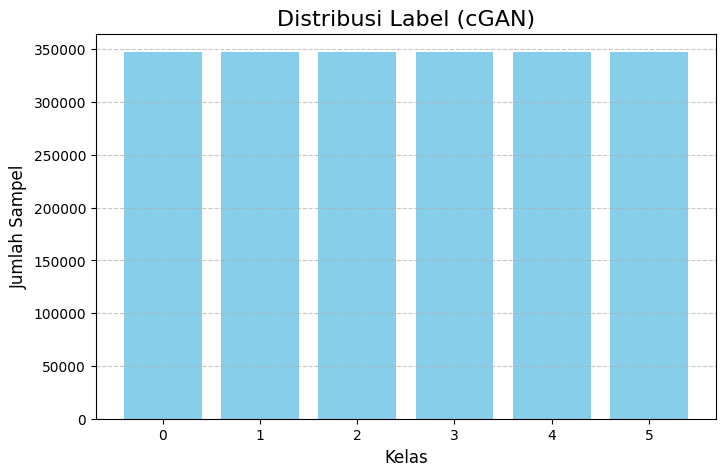

In [36]:
# Plot with cGAN
plt.figure(figsize=(8, 5))
unique, counts = np.unique(y_balanced, return_counts=True)
plt.bar(unique, counts, color='skyblue')
plt.title("Distribusi Label (cGAN)", fontsize=16)
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah Sampel", fontsize=12)
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data fortraining dan testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# RandomForest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training
rf_model.fit(X_train, y_train)

# Prediction
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy (cGAN):", accuracy_score(y_test, y_pred))
print("Classification Report (cGAN):")
print(classification_report(y_test, y_pred))


Accuracy (cGAN): 0.9305426966453835
Classification Report (cGAN):
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     69486
           1       0.78      0.81      0.80     69486
           2       0.99      0.98      0.99     69486
           3       0.99      0.99      0.99     69487
           4       0.94      0.93      0.94     69487
           5       1.00      1.00      1.00     69486

    accuracy                           0.93    416918
   macro avg       0.93      0.93      0.93    416918
weighted avg       0.93      0.93      0.93    416918



#### With SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Oversampling
X_smote, y_smote = smote.fit_resample(X, y)


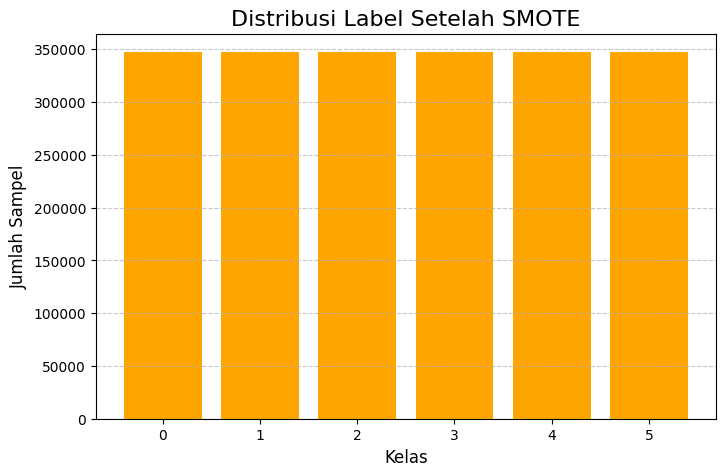

In [20]:
# Plot with SMOTE
plt.figure(figsize=(8, 5))
unique, counts = np.unique(y_smote, return_counts=True)
plt.bar(unique, counts, color='orange')
plt.title("Distribusi Label (SMOTE)", fontsize=16)
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah Sampel", fontsize=12)
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
# Split data for training dan testing
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Randomforest Classifier
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Prediction
y_pred_smote = rf_model_smote.predict(X_test_smote)

# Evaluate
print("Accuracy (SMOTE):", accuracy_score(y_test_smote, y_pred_smote))
print("Classification Report (SMOTE):")
print(classification_report(y_test_smote, y_pred_smote))


Akurasi (SMOTE): 0.9199506857463577
Laporan Klasifikasi (SMOTE):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     69486
           1       0.79      0.74      0.76     69486
           2       0.98      0.99      0.99     69486
           3       0.99      0.99      0.99     69487
           4       0.91      0.94      0.92     69487
           5       0.99      1.00      0.99     69486

    accuracy                           0.92    416918
   macro avg       0.92      0.92      0.92    416918
weighted avg       0.92      0.92      0.92    416918

